In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

In [3]:
import topaz.mrc as mrc
from topaz.utils.data.loader import load_image

## Load the training data

First, make sure the data for this section has been downloaded into the "data" directory. It is available here:
- http://bergerlab-downloads.csail.mit.edu/cryoEM-DL-intro-2019/proteasome_stack.mrcs

In [4]:
with open('data/proteasome_stack.mrcs', 'rb') as f:
    content = f.read()
    stack,_,_ = mrc.parse(content)
stack.shape

(49954, 400, 400)

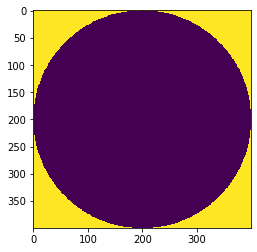

In [5]:
xx,yy = np.meshgrid(np.arange(stack.shape[1]), np.arange(stack.shape[2]), indexing='ij')
xx = xx - stack.shape[1]/2
yy = yy - stack.shape[2]/2
d = xx**2 + yy**2
mask = d > stack.shape[1]**2/4
plt.imshow(mask)

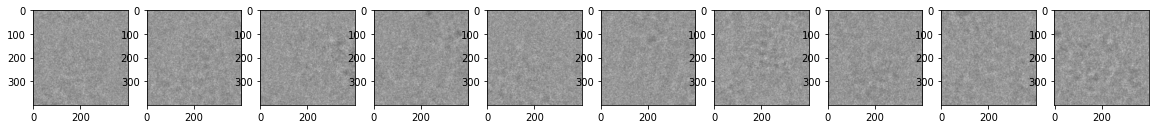

In [8]:
## take a quick look at a few positive images (particles) and a few negative images (background regions)
_,axs = plt.subplots(1,10,figsize=(20,2))
for i in range(10):
    # there is a lot of extra space around the particles in these images
    # so we'll crop to 21x21
    x = stack[i]
    mu = x[mask].mean()
    std = x[mask].std()
    x = (x - mu)/std
    axs[i].imshow(x, cmap='Greys_r', vmin=-3, vmax=3, interpolation='gaussian')

In [9]:
x = stack
mu = x[:,mask].mean(axis=1)
std = x[:,mask].std(axis=1)
x = (x - mu[:,np.newaxis,np.newaxis])/std[:,np.newaxis,np.newaxis]

In [10]:
random = np.random.RandomState(42)
order = random.permutation(len(x))
n = int(0.1*len(x))
x_val = x[order[:n]]
x_train = x[order[n:]]

In [17]:
x_train.shape

(44959, 400, 400)

# Train a fully connected autoencoder

In [23]:
n,m = stack.shape[1:]

z_dim = 2

encoder = nn.Sequential(
    nn.Linear(n*m, 500),
    nn.ReLU(inplace=True),
    nn.Linear(500, z_dim),
)

decoder = nn.Sequential(
    nn.Linear(z_dim, 500),
    nn.ReLU(inplace=True),
    nn.Linear(500, n*m),
)

In [24]:
size = stack.shape[1]*stack.shape[2]

In [25]:
use_cuda = True
torch.cuda.set_device(0)
if use_cuda:
    encoder.cuda()
    decoder.cuda() # move the model to the GPU

In [31]:
dataset_train = torch.utils.data.TensorDataset(torch.from_numpy(x_train))
dataset_val = torch.utils.data.TensorDataset(torch.from_numpy(x_val))

# we'll use stochastic gradient descent with momentum. see https://pytorch.org/docs/stable/optim.html
# for SGD variants provided by pytorch
params = list(encoder.parameters()) + list(decoder.parameters())
#optim = torch.optim.SGD(params, lr=0.01, momentum=0.9)
optim = torch.optim.Adam(params, lr=0.0003)

batch_size = 256
train_iterator = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_iterator = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size)

In [32]:
# lets train the model for 20 epochs measuring performance on the validation set after each one
num_epochs = 20

train_loss = []
val_loss = []

for epoch in range(1, num_epochs+1):
    encoder.train() # puts the model in "training" mode. not relevant here but important for certain layers
    decoder.train()
    
    # for tracking performance over the epoch
    n = 0
    loss_accum = 0
    
    for x_batch, in train_iterator:
        if use_cuda:
            x_batch = x_batch.cuda()
            
        x_batch = x_batch.view(-1, size)
        z = encoder(x_batch) # encode each image
        x_hat = decoder(z) # decode each image
        
        # calculate squared error between input and reconstruction
        loss = F.mse_loss(x_hat, x_batch)
        
        # backpropogating the gradient through the network
        loss.backward() # the core of all deep learning frameworks is automatic differentiation
        
        # update the parameters by taking a gradient step
        optim.step()
        optim.zero_grad() # zero out the stored gradients
        
        # track performance metrics over the epoch
        # this is the online mean algorithm
        b = x_batch.size(0)
        n += b
        
        delta = loss.item() - loss_accum # .item() is important to detach the compute graph!
        loss_accum += b*delta/n
        
    # training set metrics for this epoch
    train_loss.append(loss_accum)
    print(epoch, 'train', loss_accum)
    
    # now, evaluate the performance on the validation set
    encoder.eval()
    decoder.eval()
    
    n = 0
    loss_accum = 0
    
    with torch.no_grad(): # disables storing the compute graph for backpropogation
        for x_batch, in val_iterator:
            if use_cuda:
                x_batch = x_batch.cuda()

            x_batch = x_batch.view(-1, size)
            
            z = encoder(x_batch)
            x_hat = decoder(z)
                
            loss = F.mse_loss(x_hat, x_batch).item()
                
            b = x_batch.size(0)
            n += b

            delta = loss - loss_accum
            loss_accum += b*delta/n

    # training set metrics for this epoch
    val_loss.append(loss_accum)
    print(epoch, 'val', loss_accum)
        

1 train 1.0536535192541931
1 val 1.0014954076276288
2 train 1.0015884977676828
2 val 1.001465281495103
3 train 1.0014796901415794
3 val 1.001459504748966
4 train 1.0014404325039343
4 val 1.0014572977423075
5 train 1.0014273675778456
5 val 1.0014531346532078
6 train 1.001409008223014
6 val 1.0014352583909056
7 train 1.001372396705991
7 val 1.0013873195266343
8 train 1.0012992262673222
8 val 1.0013293324051433
9 train 1.0012438530021375
9 val 1.0012915638235358
10 train 1.0012087892543682
10 val 1.0012678568069644
11 train 1.0011848329280695
11 val 1.0012504478593962
12 train 1.0011622584421072
12 val 1.001233279740846
13 train 1.0011333338733195
13 val 1.001200618686619
14 train 1.0010887501584949
14 val 1.001145551703475
15 train 1.0010095145577795
15 val 1.0010708961878212
16 train 1.000937958364398
16 val 1.001021514736019
17 train 1.0008875687443337
17 val 1.0009937706652345
18 train 1.000859814703699
18 val 1.0009813866935096
19 train 1.0008405665517255
19 val 1.0009721590114666
20

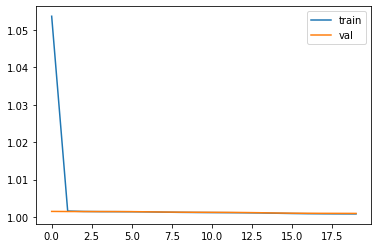

In [33]:
# plot the training results
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend(loc='best')

In [35]:
# now, let's encode all of the validation images
z = np.zeros((len(x_val), z_dim), dtype=np.float32)
with torch.no_grad():
    for i in range(len(x_val)):
        xi = torch.from_numpy(x_val[i]).view(1, size)
        if use_cuda:
            xi = xi.cuda()
        zi = encoder(xi).squeeze().cpu().numpy()
        z[i] = zi

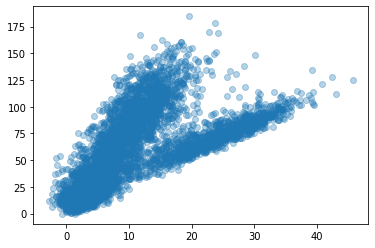

In [38]:
# how do our images fall in the 2-d embedding space
plt.scatter(z[:,0], z[:,1], alpha=0.33)

In [42]:
#now, let's map from the embedding space back to images through the decoder
zmi = np.min(z, axis=0)
zma = np.max(z, axis=0)

n,m = stack.shape[1:]
x_recon = np.zeros((20*n, 20*m))

with torch.no_grad():
    for i,z0 in enumerate(np.linspace(zma[0], zmi[0], 20)):
        for j,z1 in enumerate(np.linspace(zmi[1], zma[1], 20)):
            z_g = np.array([z0, z1], dtype=np.float32)
            z_g = torch.from_numpy(z_g).unsqueeze(0)
            if use_cuda:
                z_g = z_g.cuda()
            x_g = decoder(z_g).squeeze().cpu().numpy()
            x_recon[i*n:(i+1)*n,j*m:(j+1)*m] = x_g.reshape(n,m)        

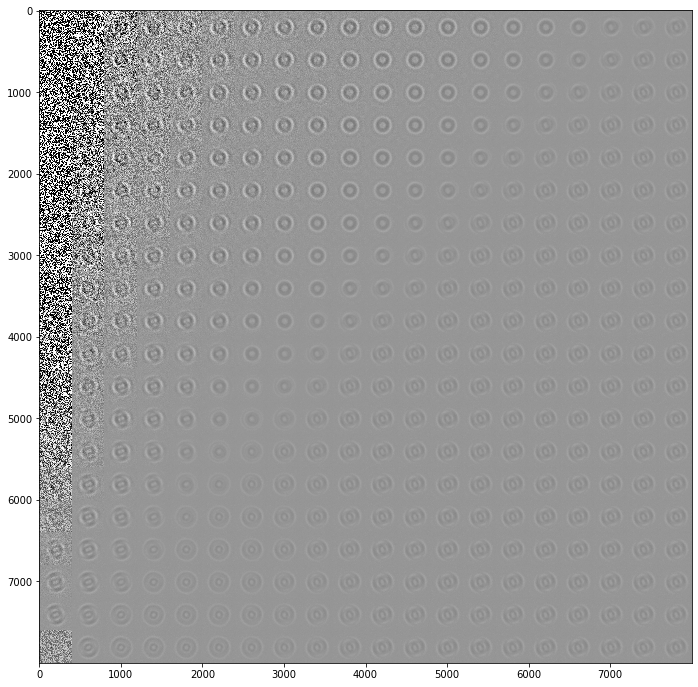

In [46]:
_,ax = plt.subplots(figsize=(12,12))
ax.imshow(x_recon, cmap='Greys_r', vmin=-1, vmax=1)

# Constrain the embedding density with a variational autoencoder

In [60]:
n,m = stack.shape[1:]

z_dim = 2

encoder = nn.Sequential(
    nn.Linear(n*m, 500),
    nn.ReLU(inplace=True),
    nn.Linear(500, z_dim*2),
)

decoder = nn.Sequential(
    nn.Linear(z_dim, 500),
    nn.ReLU(inplace=True),
    nn.Linear(500, n*m),
)

In [61]:
size = stack.shape[1]*stack.shape[2]

In [62]:
use_cuda = True
torch.cuda.set_device(0)
if use_cuda:
    encoder.cuda()
    decoder.cuda() # move the model to the GPU

In [63]:
dataset_train = torch.utils.data.TensorDataset(torch.from_numpy(x_train))
dataset_val = torch.utils.data.TensorDataset(torch.from_numpy(x_val))

# we'll use stochastic gradient descent with momentum. see https://pytorch.org/docs/stable/optim.html
# for SGD variants provided by pytorch
params = list(encoder.parameters()) + list(decoder.parameters())
#optim = torch.optim.SGD(params, lr=0.01, momentum=0.9)
optim = torch.optim.Adam(params, lr=0.0001)

batch_size = 256
train_iterator = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_iterator = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size)

In [64]:
# lets train the model for 20 epochs measuring performance on the validation set after each one
num_epochs = 20

train_loss = []
val_loss = []

for epoch in range(1, num_epochs+1):
    encoder.train() # puts the model in "training" mode. not relevant here but important for certain layers
    decoder.train()
    
    # for tracking performance over the epoch
    n = 0
    loss_accum = 0
    
    for x_batch, in train_iterator:
        if use_cuda:
            x_batch = x_batch.cuda()
            
        x_batch = x_batch.view(-1, size)
        z = encoder(x_batch) # encode each image
        z_mu = z[:,:z_dim]
        z_logstd = z[:,z_dim:]
        z_std = torch.exp(z_logstd)
        
        # sample from the posterior given by the encoder
        r = np.random.randn(*z_mu.size())
        r = torch.from_numpy(r).float()
        if use_cuda:
            r = r.cuda()
        z = z_mu + z_std*r
        
        x_hat = decoder(z) # decode each image
        
        # calculate squared error between input and reconstruction
        recon_loss = F.mse_loss(x_hat, x_batch)
        
        # calculate the kl-divergence term
        kl_div = -z_logstd + (z_std*z_std + z_mu*z_mu)/2 - 0.5
        kl_div = torch.sum(kl_div, 1).mean()/size
        
        loss = recon_loss + kl_div
        
        # backpropogating the gradient through the network
        loss.backward() # the core of all deep learning frameworks is automatic differentiation
        
        # update the parameters by taking a gradient step
        optim.step()
        optim.zero_grad() # zero out the stored gradients
        
        # track performance metrics over the epoch
        # this is the online mean algorithm
        b = x_batch.size(0)
        n += b
        
        delta = loss.item() - loss_accum # .item() is important to detach the compute graph!
        loss_accum += b*delta/n
        
    # training set metrics for this epoch
    train_loss.append(loss_accum)
    print(epoch, 'train', loss_accum)
    
    # now, evaluate the performance on the validation set
    encoder.eval()
    decoder.eval()
    
    n = 0
    loss_accum = 0
    
    with torch.no_grad(): # disables storing the compute graph for backpropogation
        for x_batch, in val_iterator:
            if use_cuda:
                x_batch = x_batch.cuda()

            x_batch = x_batch.view(-1, size)
      
            z = encoder(x_batch) # encode each image
            z_mu = z[:,:z_dim]
            z_logstd = z[:,z_dim:]
            z_std = torch.exp(z_logstd)

            # sample from the posterior given by the encoder
            r = np.random.randn(*z_mu.size())
            r = torch.from_numpy(r).float()
            if use_cuda:
                r = r.cuda()
            z = z_mu + z_std*r

            x_hat = decoder(z) # decode from the sample

            # calculate squared error between input and reconstruction
            recon_loss = F.mse_loss(x_hat, x_batch)

            # calculate the kl-divergence term
            kl_div = -z_logstd + (z_std*z_std + z_mu*z_mu)/2 - 0.5
            kl_div = torch.sum(kl_div, 1).mean()/size

            loss = recon_loss + kl_div
            loss = loss.item()
                
            b = x_batch.size(0)
            n += b

            delta = loss - loss_accum
            loss_accum += b*delta/n

    # training set metrics for this epoch
    val_loss.append(loss_accum)
    print(epoch, 'val', loss_accum)
        

1 train 1.0083844065758998
1 val 1.0025885408227744
2 train 1.0032516551846622
2 val 1.0019095947315269
3 train 1.0019118448691997
3 val 1.001814772178222
4 train 1.001729802332935
4 val 1.0018526647899957
5 train 1.0015097604309868
5 val 1.0014584865417324
6 train 1.0012725949560528
6 val 1.0013435195993492
7 train 1.0011252328783635
7 val 1.0012506308378997
8 train 1.001030007615447
8 val 1.0013231112792325
9 train 1.000955323394597
9 val 1.0011626565062604
10 train 1.0008956215958005
10 val 1.0011131867035494
11 train 1.000848318215391
11 val 1.0010785128619222
12 train 1.0008040878237083
12 val 1.001064972166304
13 train 1.0007642674651334
13 val 1.0010208716024984
14 train 1.000728324144828
14 val 1.0009985858852322
15 train 1.0006966951301257
15 val 1.000976702305409
16 train 1.0006695292636025
16 val 1.0009769666660295
17 train 1.000645755891573
17 val 1.00101342418411
18 train 1.000623606047773
18 val 1.000962796583548
19 train 1.0006006504521605
19 val 1.000946937309013
20 tra

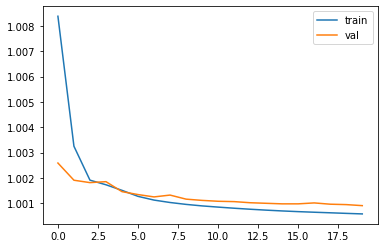

In [65]:
# plot the training results
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend(loc='best')

In [66]:
# now, let's encode all of the validation images
z_mu = np.zeros((len(x_val), z_dim), dtype=np.float32)
z_std = np.zeros((len(x_val), z_dim), dtype=np.float32)
with torch.no_grad():
    for i in range(len(x_val)):
        xi = torch.from_numpy(x_val[i]).view(1, size)
        if use_cuda:
            xi = xi.cuda()
        zi = encoder(xi).squeeze().cpu().numpy()
        z_mu[i] = zi[:z_dim]
        z_std[i] = np.exp(zi[z_dim:])

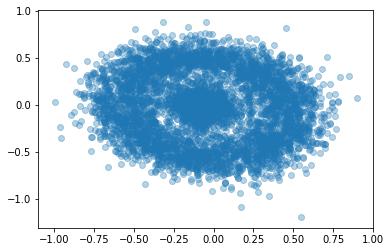

In [67]:
# how do our images fall in the 2-d embedding space
plt.scatter(z_mu[:,0], z_mu[:,1], alpha=0.33)

In [70]:
#now, let's map from the embedding space back to images through the decoder
#zmi = np.min(z_mu, axis=0)
#zma = np.max(z_mu, axis=0)

zmi = [-1, -1]
zma = [1, 1]

n,m = stack.shape[1:]
x_recon = np.zeros((20*n, 20*m))

with torch.no_grad():
    for i,z0 in enumerate(np.linspace(zma[0], zmi[0], 20)):
        for j,z1 in enumerate(np.linspace(zmi[1], zma[1], 20)):
            z_g = np.array([z0, z1], dtype=np.float32)
            z_g = torch.from_numpy(z_g).unsqueeze(0)
            if use_cuda:
                z_g = z_g.cuda()
            x_g = decoder(z_g).squeeze().cpu().numpy()
            x_recon[i*n:(i+1)*n,j*m:(j+1)*m] = x_g.reshape(n,m)        

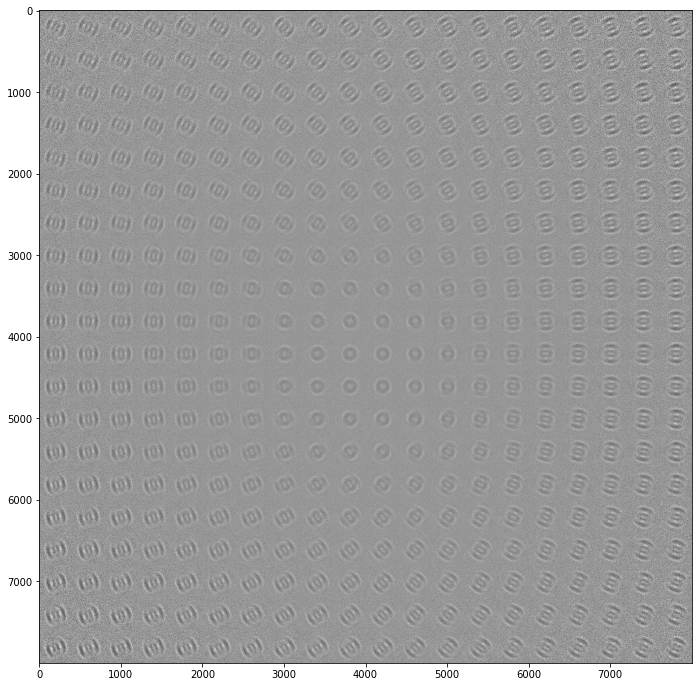

In [71]:
_,ax = plt.subplots(figsize=(12,12))
ax.imshow(x_recon, cmap='Greys_r', vmin=-1, vmax=1)